In [1]:
import src.gen_synthetic as gen_data
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
import src.onlineSLE as utility
import periodicity_detection as period


## Reproduct Figuer 2

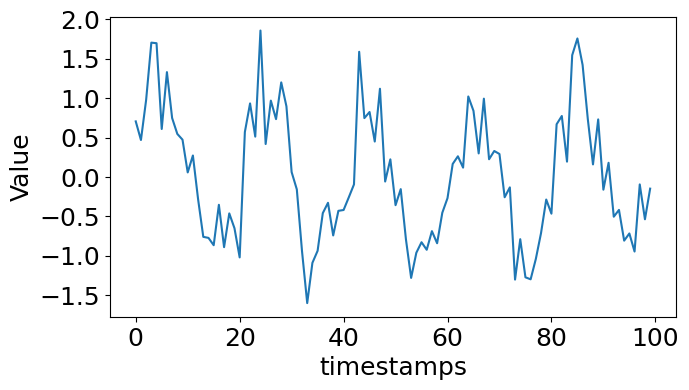

<Figure size 640x480 with 0 Axes>

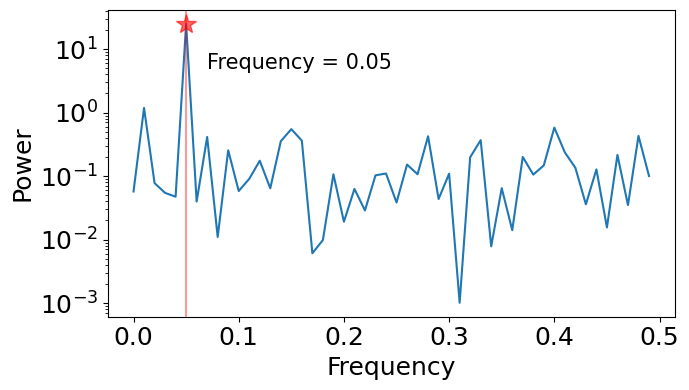

<Figure size 640x480 with 0 Axes>

In [2]:
np.random.seed(0)
ts = np.array(gen_data.sinewave(100,20,1))
R_t = 0.4 * np.random.randn(len(ts))
ts= R_t + ts


## Periodogram using FFT
start_fft = fft(ts)
xfreq, pden = utility.peridogram(len(ts),start_fft)
max_idx = np.argmax(pden)
max_idx = np.argmax(pden)


plt.figure(figsize=(7,4))
plt.plot(ts)
plt.xlabel('timestamps', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()
plt.clf()

plt.figure(figsize=(7,4))
plt.semilogy(xfreq, pden)
plt.plot(xfreq[max_idx], pden[max_idx], 'r*', markersize=15, alpha = 0.6)
plt.axvline(x=xfreq[max_idx], color = 'red', alpha= 0.4)
plt.text(xfreq[max_idx]+0.02, pden[max_idx]-20, 'Frequency = 0.05', fontsize=15)
plt.xlabel('Frequency', fontsize=18)
plt.ylabel('Power', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()
plt.clf()


## Generate dataset

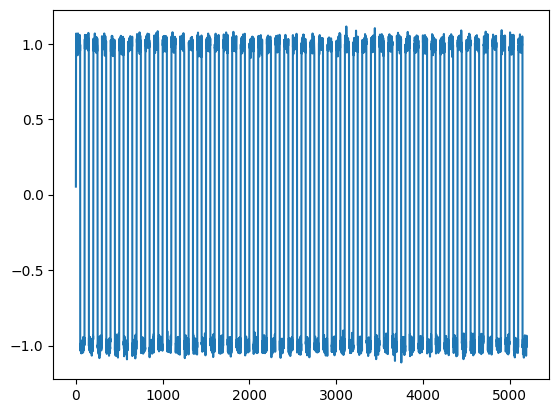

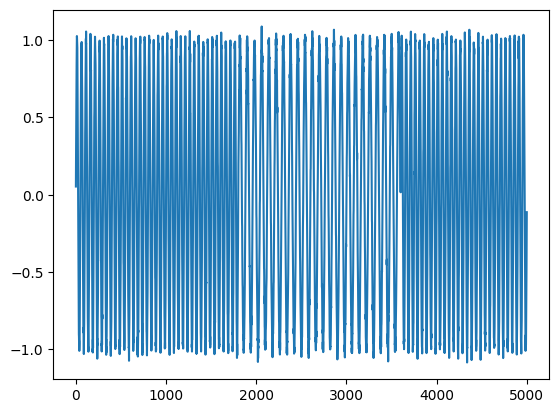

In [3]:
# Two synthetic dataset
syn1 = gen_data.generate_syn1()
syn2 = gen_data.generate_syn2()

plt.plot(syn1['ts'])
plt.show()

plt.plot(syn2['ts'])
plt.show()

# Seasonal Length Estimation Accuracy Rate

In [4]:
dataset_names = ['syn1', 'syn2']
datasets = [syn1['ts'], syn2['ts']]
answers = [syn1['ground_truth'], syn2['ground_truth']]
sliding_window_sizes = [500, 400]

# For example : ACF
for dataset_name, dataset, answer, sliding_window_size in zip (dataset_names, datasets, answers, sliding_window_sizes):
    acf_result = []
    for idx in range(len(dataset) - sliding_window_size + 1):
        W = dataset[idx:sliding_window_size + idx]
        SLE_result = period.autocorrelation(W)
        
        acf_result.append({'idx_win': sliding_window_size + idx,
                                    'answer': answer[sliding_window_size + idx - 1],
                                    'result': SLE_result})
    
    print(utility.result_aggregation(dataset_name, 'ACF',acf_result))

[{'dataset_name': 'syn1', 'algorithms': 'ACF', 'error_bound': 0, 'accuracy_ratio': 1.0}, {'dataset_name': 'syn1', 'algorithms': 'ACF', 'error_bound': 20, 'accuracy_ratio': 1.0}]
[{'dataset_name': 'syn2', 'algorithms': 'ACF', 'error_bound': 0, 'accuracy_ratio': 0.6826776787654858}, {'dataset_name': 'syn2', 'algorithms': 'ACF', 'error_bound': 20, 'accuracy_ratio': 0.8739404477287546}]


## OnlineSLE

In [5]:

for dataset_name, dataset, answer, sliding_window_size in zip (dataset_names, datasets, answers, sliding_window_sizes):
    ## offline mode
    onlineSLE_result = []
    W = dataset[:sliding_window_size]
    mathcal_F = fft(W)
    xfreq, periodogram_den = utility.peridogram(sliding_window_size, mathcal_F)
    peak_index = utility.get_period_hints(periodogram_den)
    if peak_index > 1:
        frequency = xfreq[peak_index]
        SLE_result = round(1 / frequency)
    else:
        SLE_result = 1
    onlineSLE_result.append({'idx_win': sliding_window_size,
                    'answer': answer[sliding_window_size - 1],
                    'result': SLE_result})
    
    ## online mode
    for idx, x_t in enumerate(dataset[sliding_window_size:]):
        x_oldest = W[0]
        W = W[1:]
        W = np.append(W, x_t)
        mathcal_F = utility.update_sDFT(mathcal_F, x_oldest, x_t)
        xfreq, periodogram_den = utility.peridogram(sliding_window_size, mathcal_F)
        peak_index = utility.get_period_hints(periodogram_den)
        if peak_index > 1:
            frequency = xfreq[peak_index]
            SLE_result = round(1 / frequency)
        else:
            SLE_result = 1
        
        onlineSLE_result.append({'idx_win': 1 + sliding_window_size + idx,
                                    'answer': answer[sliding_window_size + idx],
                                    'result': SLE_result})
        
    print(utility.result_aggregation(dataset_name, 'onlineSLE', onlineSLE_result))

[{'dataset_name': 'syn1', 'algorithms': 'onlineSLE', 'error_bound': 0, 'accuracy_ratio': 1.0}, {'dataset_name': 'syn1', 'algorithms': 'onlineSLE', 'error_bound': 20, 'accuracy_ratio': 1.0}]
[{'dataset_name': 'syn2', 'algorithms': 'onlineSLE', 'error_bound': 0, 'accuracy_ratio': 0.9093675287980874}, {'dataset_name': 'syn2', 'algorithms': 'onlineSLE', 'error_bound': 20, 'accuracy_ratio': 0.9093675287980874}]
